In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# Import CSV Files

In [2]:
#Checking the data
Cus_df =pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/Customer Acqusition.csv")
Repay_df=pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/Repayment.csv")
Spend_df=pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/spend.csv")

Cus_cy_df=Cus_df.copy()
Repay_cy_df=Repay_df.copy()
Spend_cy_df=Spend_df.copy()

#Spend_df.sample(5)

# Checking and Cleaning data

In [3]:
# Checking for missing data

"""
No Missing Data 
Cus_df.isnull().sum()
Spend_df.isnull().sum()
Repay_df.isnull().sum() - missing data

"""
#Cus_df.describe(include='all')
#Spend_df.describe(include='all')
#Repay_df.describe(include='all')


'\nNo Missing Data \nCus_df.isnull().sum()\nSpend_df.isnull().sum()\nRepay_df.isnull().sum() - missing data\n\n'

In [4]:
#check num col and row in Repay_df
Repay_df.shape

#Drop Unnamed:4 column - it is uncessary columns
#Fill NAN with its index+1 in the columns SL No: - we might need it later on
Repay_cy_df = Repay_cy_df.drop(labels='Unnamed: 4', axis=1)
Repay_cy_df['SL No:'] = Repay_cy_df.index+1
Repay_cy_df = Repay_cy_df.dropna()

#Corret Spelling
Cus_cy_df = Cus_df.rename(columns={"Product":"Tier"})
Cus_cy_df['Tier'] = Cus_cy_df['Tier'].replace('Platimum', 'Platinum')

Spend_cy_df['Type']= Spend_cy_df['Type'].replace('PETRO','PETROL')



#Clean_Repay_df.shape
#Cus_df['Customer'].shape
#Cus_cy_df

In [5]:
#Additional Categories 

def agegroup (age):
    if age >=13 and age <18:
        return 'Teenager'
    elif age >= 18 and age <65:
        return 'Adults'
    elif age >= 65:
        return 'OlderAdults'
Cus_cy_df['AgeGroup'] = Cus_cy_df['Age'].apply(agegroup)


In [6]:
Repay_cy_df.head()

,SL No:,Customer,Month,Amount
0,1,A1,12-Jan-04,495414.75
1,2,A1,3-Jan-04,245899.02
2,3,A1,15-Jan-04,259490.06
3,4,A1,25-Jan-04,437555.12
4,5,A1,17-Jan-05,165972.88


# Thing to look into

1. Who is our cilent?
2. What is their spending habit? monthly/quarterly/yearly?
3. Identify the most popular products/services for which the credit card is used
3. How many spent within their credit card monthly?
1. What product is spend on the most on each of the city?

1. Identify factors that are most indicative of a customer being at risk of defaulting on their credit card payments.
1.Investigate if there's a correlation between spending and repayment ability across different age groups or cities.


1. **Credit Score Prediction:** Build a model to predict future credit scores based on spending and repayment habits.

2. **Churn Prediction:** Use machine learning algorithms to predict which customers are most likely to churn in the future.

1. **Credit Limit Recommendations:** Develop a model to recommend credit limit adjustments based on a customer's spending and repayment history.
2. **Targeted Marketing:** Use customer segmentation to develop targeted marketing strategies. For example, offering premium cards to high-value segments.




# Visualisation of the data

In [7]:
#Load Visualisation Plugin

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px

# from matplotlib.colors import ListedColormap


sns.set()

In [8]:
# Cus_N_Spend_df.loc[Cus_N_Spend_df['Tier']=='Silver'].count
#Cus_cy_df.loc[Cus_cy_df['Tier']=='Silver']

In [9]:
Cus_N_Spend_df = pd.merge(Cus_cy_df,Spend_cy_df,on='Customer',how='inner')
Cus_N_Spend_df['Limit'].unique()

sorted_tiers = ['Silver', 'Gold', 'Platinum']

grouped_data = Cus_N_Spend_df.groupby('Tier')['Type'].value_counts()
grouped_sum = Cus_N_Spend_df.groupby('Tier')['Type'].count()
grouped_Amount_sum = Cus_N_Spend_df.groupby('Tier')['Amount'].sum()

table = grouped_data.unstack().fillna(0)
table['Total Count'] = grouped_sum
table['Amount'] =  grouped_Amount_sum.apply(lambda x: "{:,.0f}".format(x))

sorted_table = table.reindex(sorted_tiers)
sorted_table.index.name = None

sorted_table.rename(columns={'Type': 'Tier'}, inplace=True)
sorted_table.rename_axis(columns=None, inplace=True)
sorted_table
# sorted_table.describe()

,AIR TICKET,AUTO,BIKE,BUS TICKET,CAMERA,CAR,CLOTHES,FOOD,JEWELLERY,MOVIE TICKET,PETROL,RENTAL,SANDALS,SHOPPING,TRAIN TICKET,Total Count,Amount
Silver,31,6,7,18,37,5,21,30,19,19,45,17,8,22,35,320,"77,128,966"
Gold,63,14,17,45,75,12,33,62,31,25,83,34,11,45,60,610,"146,200,355"
Platinum,53,20,25,36,48,13,41,68,45,32,72,25,9,46,37,570,"141,314,753"


In [10]:
Cus_N_Spend_df.head(5)

,No,Customer,Age,City,Tier,Limit,Company,Segment,AgeGroup,Sl No:,Month,Type,Amount
0,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,1,12-Jan-04,JEWELLERY,485470.80
1,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,2,3-Jan-04,PETROL,410556.13
2,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,3,15-Jan-04,CLOTHES,23740.46
3,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,4,25-Jan-04,FOOD,484342.47
4,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,5,17-Jan-05,CAMERA,369694.07


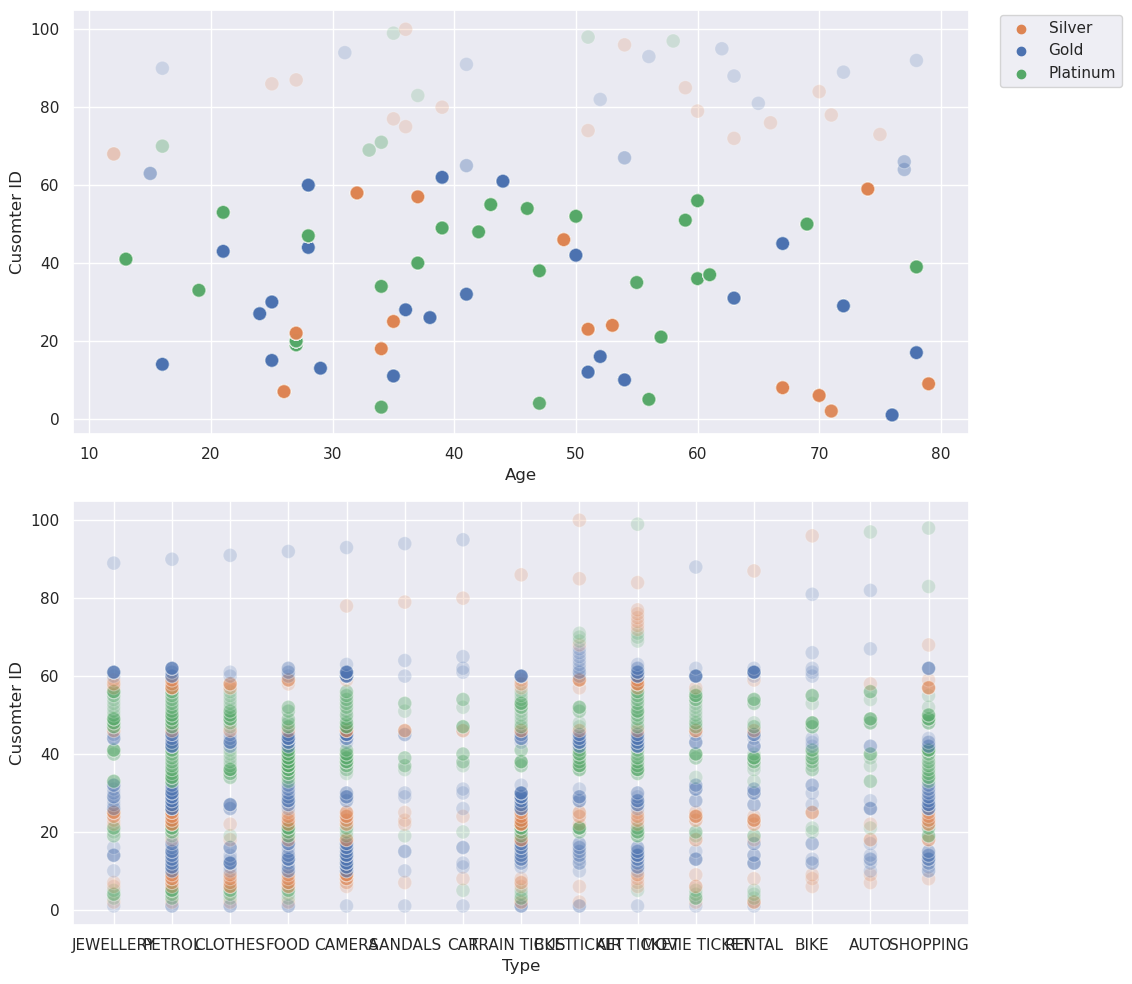

In [11]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

# Create the first scatter plot on the first subplot
sns.scatterplot(x='Age', y='No', hue='Tier', data=Cus_N_Spend_df,s=100,alpha=0.2, ax=axes[0])

sns.scatterplot(x='Type', y='No', hue='Tier', data=Cus_N_Spend_df,s=100,alpha=0.2 ,ax=axes[1])

# Remove the legend from the first subplot
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Add the legend outside the subplots
handles, labels = axes[0].get_legend_handles_labels()

preferred_order = ['Silver', 'Gold', 'Platinum']
sorted_handles, sorted_labels = zip(*sorted(zip(handles, labels), key=lambda x: preferred_order.index(x[1])))

fig.legend(sorted_handles,sorted_labels, loc='upper left', bbox_to_anchor=(1, 0.985))


ylabel = "Cusomter ID"
axes[0].set_ylabel(ylabel = ylabel)
axes[1].set_ylabel(ylabel = ylabel)

plt.tight_layout()
plt.show()

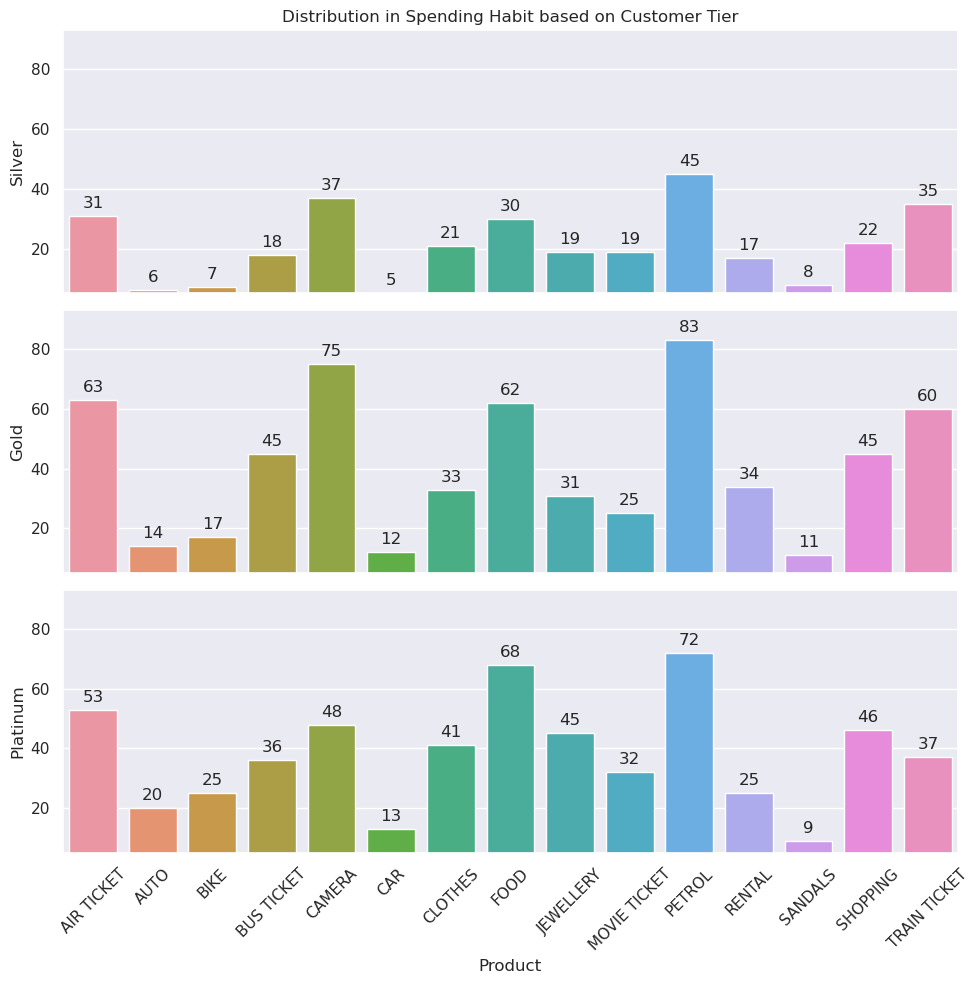

In [12]:
#What are their spending habit in differnt Teir?

# Assuming 'Type' is the column containing the type of spend
data_merged = Cus_N_Spend_df.groupby(['Tier', 'Type']).size().reset_index(name='Count')
order = data_merged['Type'].value_counts().index

# Filter data by a specific product, e.g., 'Platinum'
filtered_data_ax1 = data_merged[data_merged['Tier'] == 'Gold']
filtered_data_ax2 = data_merged[data_merged['Tier'] == 'Silver']
filtered_data_ax3 = data_merged[data_merged['Tier'] == 'Platinum']

# Set up the matplotlib figure
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10, 10), sharex=True)


sns.barplot(data=filtered_data_ax2, x='Type', y='Count',ax=ax1)
ax1.set_ylabel("Silver")

sns.barplot(data=filtered_data_ax1, x='Type', y='Count',ax=ax2)
ax2.set_ylabel("Gold")

sns.barplot(data=filtered_data_ax3, x='Type', y='Count',ax=ax3)
ax3.set_ylabel("Platinum")


ax1.set_title('Distribution in Spending Habit based on Customer Tier')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('Product')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Set y-axis limits to min and max values
ax1.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)
ax2.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)
ax3.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)


# Annotate values on the bars
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

annotate_bars(ax1)
annotate_bars(ax2)
annotate_bars(ax3)

# Finalize the plot
plt.tight_layout(h_pad=1)
plt.show()


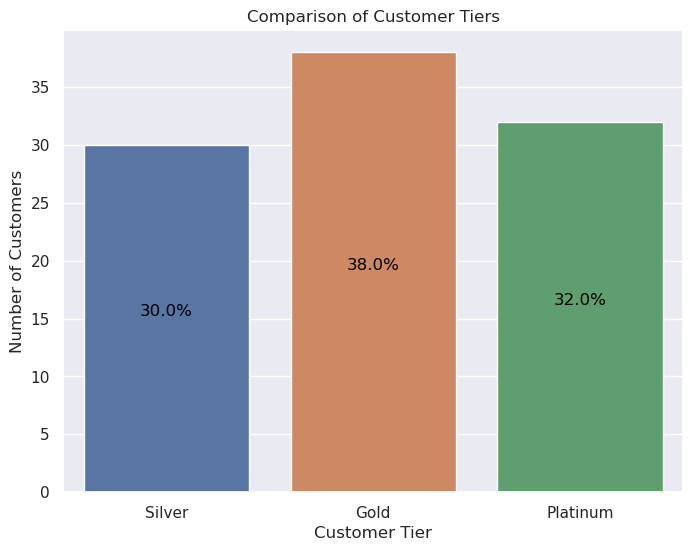

In [13]:
#What is % of each tier in our customer?

plt.figure(figsize=(8, 6))

# Calculate total number of customers
total_customers = len(Cus_cy_df)

tier_order = ['Silver','Gold', 'Platinum'] 
ax = sns.countplot(data=Cus_cy_df,x='Tier',order=tier_order)

# Set labels and title
plt.xlabel('Customer Tier')
plt.ylabel('Number of Customers')
plt.title('Comparison of Customer Tiers')


# Add text labels on top of each bar
for p in ax.patches:
    percentage = p.get_height() / total_customers * 100
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

    
plt.show()

In [14]:
Cus_N_Spend_df.head()

,No,Customer,Age,City,Tier,Limit,Company,Segment,AgeGroup,Sl No:,Month,Type,Amount
0,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,1,12-Jan-04,JEWELLERY,485470.80
1,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,2,3-Jan-04,PETROL,410556.13
2,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,3,15-Jan-04,CLOTHES,23740.46
3,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,4,25-Jan-04,FOOD,484342.47
4,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdults,5,17-Jan-05,CAMERA,369694.07


<Figure size 1000x1000 with 0 Axes>

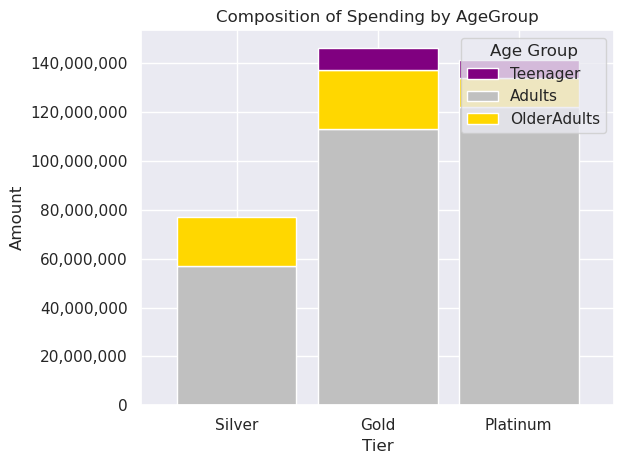

In [15]:
# Sorting the data by 'Tier' and 'AgeGroup'
amount_sum_by_agegroup_type = Cus_N_Spend_df.groupby(['AgeGroup', 'Tier'])['Amount'].sum().reset_index()
amount_sum_by_agegroup_type.sort_values(['Tier', 'AgeGroup'], inplace=True)

# Create the pivot data again
pivot_data = amount_sum_by_agegroup_type.pivot(index='Tier', columns='AgeGroup', values='Amount')


plt.figure(figsize=(10, 10))

# Create the plot
ax = pivot_data.loc[['Silver', 'Gold', 'Platinum']].plot(kind='bar', stacked=True, color=['silver','gold','purple'], width=0.85)

# Set labels and title
plt.xlabel('Tier')
plt.ylabel('Amount')
plt.title('Composition of Spending by AgeGroup')

# Set the order of x-axis ticks
ax.set_xticklabels(['Silver', 'Gold', 'Platinum'])

# Rotate x-axis labels for better visibility
plt.xticks(rotation=0)

# Format y-axis ticks with thousands separator
from matplotlib import ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Set the order and title for legends
handles, labels = ax.get_legend_handles_labels()
preferred_order_agegroup = ['Teenager', 'Adults', 'OlderAdults']
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: preferred_order_agegroup.index(x[0])))
ax.legend(handles, labels, title='Age Group', loc='upper right')


plt.tight_layout()
plt.show()


In [16]:
#Where do most of our credit user lives?

# #data
# amount_sum_by_city_type=Cus_N_Spend_df.groupby(['City','Tier'])['Amount'].sum().reset_index()
# tier_counts_by_city = Cus_N_Spend_df.groupby(['City', 'Tier']).size().reset_index(name='Tier_Count')

# result_df = pd.merge(amount_sum_by_city_type, tier_counts_by_city, on=['City', 'Tier'])

# fig = px.treemap(result_df,path=['City','Tier'],values='Amount',custom_data='Tier_Count')


# # Update hover template for formatting
# fig.update_traces(
# #     hovertemplate='<b>%{label}</b><br>Value: $%{Amount[0]:,.2f}'
#     hovertemplate='<b>%{label}</b><br>Amount: $%{value:,.2f}<br>Number of Tier: %{customdata[0]}'
# )

# # Update layout for better visualization
# fig.update_layout(
#     margin=dict(l=20, r=20, t=30, b=20),
#     title='Sample Treemap',
# )

# # Show the plot
# fig.show()


In [17]:
# Create a new DataFrame that sums up the Amount and Tier_Count for each City
# summed_df = result_df.groupby('City').agg({
#     'Amount': 'sum',
#     'Tier_Count': 'sum'
# }).reset_index()
#summed_df 

In [18]:
#How much is their credit card limited? Avg Med?

# Define is_skewed function
def is_skewed(mean, median):
    if mean > median:
        return 'Right'
    elif mean < median:
        return 'Left'
    else:
        return 'Symmetric'

# Group by 'Tier' and then aggregate
summary_stats = Cus_cy_df.groupby('Tier')['Limit'].agg(['count','median','mean','std', 'sum']).round(2).reset_index() 
summary_stats['skew'] = summary_stats.apply(lambda row: is_skewed(row['mean'], row['median']), axis=1)
#summary_stats['var'] = summary_stats['var'].apply(lambda x:'{:,.0f}'.format(x))

summary_stats

#how does bank deal with values that have more then 2 decimal place?

,Tier,count,median,mean,std,sum,skew
0,Gold,38,500000.0,500000.00,0.00,19000000.0,Symmetric
1,Platinum,32,10002.0,139688.47,197344.55,4470031.0,Right
2,Silver,30,100001.5,166667.67,151619.15,5000030.0,Right


In [19]:
mode_values = Cus_cy_df.groupby('Tier')['Limit'].describe().round(2).reset_index()
mode_values

,Tier,count,mean,std,min,25%,50%,75%,max
0,Gold,38.0,500000.00,0.00,500000.0,500000.0,500000.0,500000.0,500000.0
1,Platinum,32.0,139688.47,197344.55,10000.0,10001.0,10002.0,100003.0,500000.0
2,Silver,30.0,166667.67,151619.15,100000.0,100000.0,100001.5,100003.0,500000.0


In [20]:
#Clean_Repay_df
#Cus_df.nunique()
#Cus_df.info()
#Spend_df

# SandBox Area

In [21]:
# #Using PLT
# # Count the occurrences of each tier
# tier_counts = Cus_df['Tier'].value_counts().sort_values(ascending=True)

# # Extract labels and counts
# labels = tier_counts.index
# counts = tier_counts.values

# # Create a bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(labels, counts, color=['gold', 'silver', 'blue'])

# # Set labels and title
# plt.xlabel('Customer Tier')
# plt.ylabel('Number of Customers')
# plt.title('Distribution of Customer Tiers')

# # Show the plot
# plt.show()

In [22]:
# Price_list = {'Cheeseburger': 8, 'Fries': 5, 'Lasagna': 12, 'Soup': 5, 'Spaghetti': 10}

# print(Price_list['Spaghetti'])
# Price_list.get('Spaghetti')


# #reassign all the key to different meaning.


In [23]:
# nums = [1,35,12,24,31,51,70,100]


# def count (number):
#     number = sorted(number)
#     x = 0
#     while number[x]<20:
#         x+=1
#     return x
    
# count (nums)


